In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

In [ ]:
!unzip who-is-the-real-winner.zip

Archive:  who-is-the-real-winner.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2059 entries, 0 to 2058
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              2059 non-null   int64 
 1   Candidate       2059 non-null   object
 2   Constituency ∇  2059 non-null   object
 3   Party           2059 non-null   object
 4   Criminal Case   2059 non-null   int64 
 5   Total Assets    2059 non-null   object
 6   Liabilities     2059 non-null   object
 7   state           2059 non-null   object
 8   Education       2059 non-null   object
dtypes: int64(2), object(7)
memory usage: 144.9+ KB


In [ ]:
train.head()

,ID,Candidate,Constituency ∇,Party,Criminal Case,Total Assets,Liabilities,state,Education
0,0,M.K. Mohan,ANNA NAGAR,DMK,4,211 Crore+,2 Crore+,TAMIL NADU,8th Pass
1,1,Khatik Ramesh Prasad,KARERA (SC),BJP,0,1 Crore+,0,MADHYA PRADESH,12th Pass
2,2,Dr. Mantar Gowda,MADIKERI,INC,0,7 Crore+,22 Lac+,KARNATAKA,Post Graduate
3,3,Kundan Kumar,BEGUSARAI,BJP,0,9 Crore+,24 Lac+,BIHAR,Post Graduate
4,4,Swapan Majumder,BANGAON DAKSHIN (SC),BJP,2,2 Crore+,61 Lac+,WEST BENGAL,8th Pass


<ipython-input-39-97dc1205f7c9>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Education', y='Criminal Case', data=edu_crime_counts, palette='viridis')


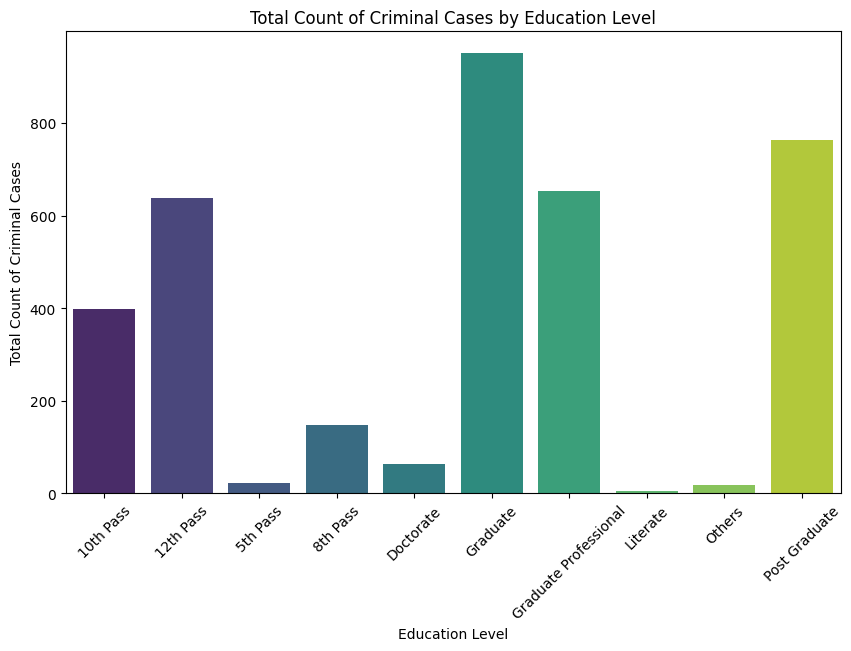

In [ ]:
edu_crime_counts = train.groupby('Education')['Criminal Case'].sum().reset_index()

# Plotting the histogram
plt.figure(figsize=(10, 6))
sns.barplot(x='Education', y='Criminal Case', data=edu_crime_counts, palette='viridis')
plt.xlabel('Education Level')
plt.ylabel('Total Count of Criminal Cases')
plt.title('Total Count of Criminal Cases by Education Level')
plt.xticks(rotation=45)
plt.show()

<ipython-input-43-f40326bc6a2e>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='state', y='Criminal Case', data=edu_crime_counts, palette='viridis')


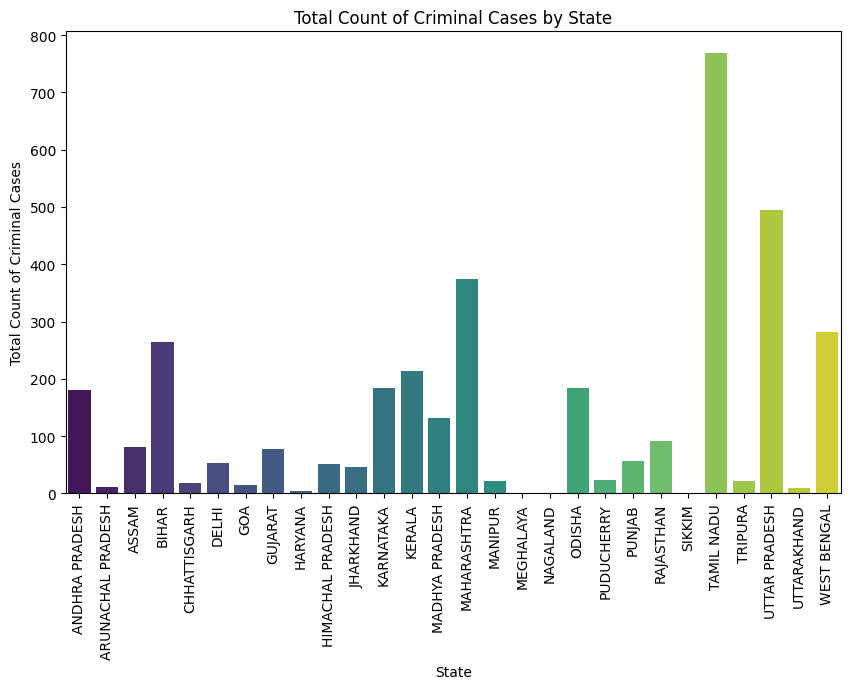

In [ ]:
edu_crime_counts = train.groupby('state')['Criminal Case'].sum().reset_index()

# Plotting the histogram
plt.figure(figsize=(10, 6))
sns.barplot(x='state', y='Criminal Case', data=edu_crime_counts, palette='viridis')
plt.xlabel('State')
plt.ylabel('Total Count of Criminal Cases')
plt.title('Total Count of Criminal Cases by State')
plt.xticks(rotation=90)
plt.show()

<ipython-input-45-f69af268a872>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Party', y='Criminal Case', data=edu_crime_counts, palette='viridis')


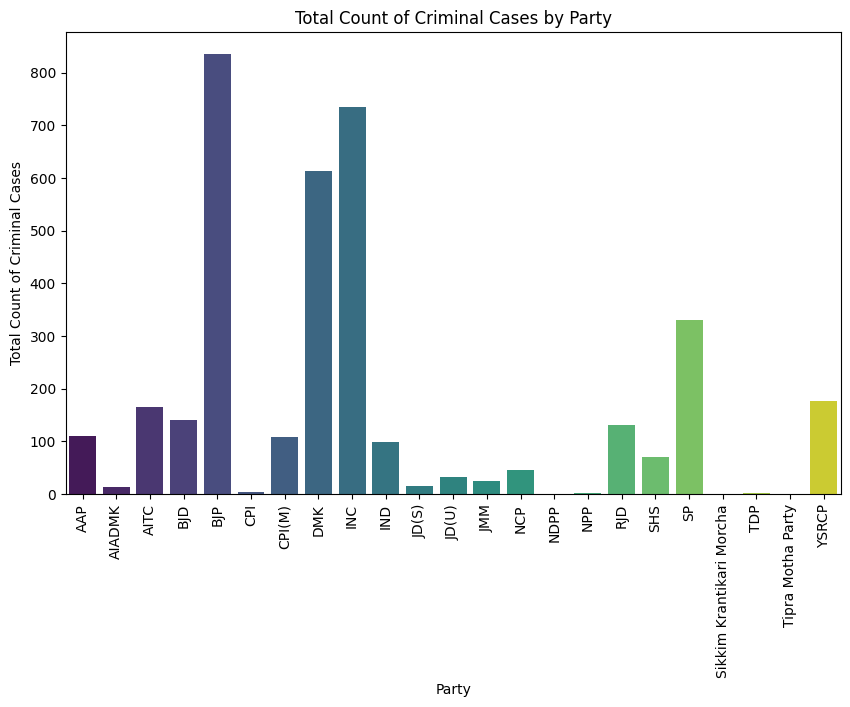

In [ ]:
edu_crime_counts = train.groupby('Party')['Criminal Case'].sum().reset_index()

# Plotting the histogram
plt.figure(figsize=(10, 6))
sns.barplot(x='Party', y='Criminal Case', data=edu_crime_counts, palette='viridis')
plt.xlabel('Party')
plt.ylabel('Total Count of Criminal Cases')
plt.title('Total Count of Criminal Cases by Party')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# The total assests and liabilities are in the form of string as "211 Crore+".
# We need to convert them to numerical values in order to make predictions.

def convert_assets_to_crore(asset_str):
    if 'Crore' in asset_str:
        return float(asset_str.split()[0])
    elif 'Lac' in asset_str:
        return float(asset_str.split()[0]) / 100  # 1 Crore = 100 Lac
    else:
        # Handle other cases as needed
        return None  # For simplicity, returning None for unknown cases

In [ ]:
# Data preprocessing

def process_train_data(data):
  train = data
  train['Total Assets (Crore INR)'] = train['Total Assets'].apply(convert_assets_to_crore)
  train['Liabilities (Crore INR)'] = train['Liabilities'].apply(convert_assets_to_crore)

  train['Total Assets (Crore INR)'].fillna(train['Total Assets (Crore INR)'].median(), inplace=True)
  train['Liabilities (Crore INR)'].fillna(train['Liabilities (Crore INR)'].median(), inplace=True)

  label_encoders = {}
  for column in ['Party', 'Constituency ∇', 'state', 'Education']:
      le = LabelEncoder()
      train[column] = le.fit_transform(train[column])
      label_encoders[column] = le

  train.drop(['ID', 'Candidate', 'Total Assets', 'Liabilities'], axis=1, inplace=True)
  return train

In [ ]:
def process_test_data(data):
  df = data
  df['Total Assets (Crore INR)'] = df['Total Assets'].apply(convert_assets_to_crore)
  df['Liabilities (Crore INR)'] = df['Liabilities'].apply(convert_assets_to_crore)

  df['Total Assets (Crore INR)'].fillna(df['Total Assets (Crore INR)'].median(), inplace=True)
  df['Liabilities (Crore INR)'].fillna(df['Liabilities (Crore INR)'].median(), inplace=True)

  label_encoders = {}
  for column in ['Party', 'Constituency ∇', 'state']:
      le = LabelEncoder()
      df[column] = le.fit_transform(df[column])
      label_encoders[column] = le

  df.drop(['ID', 'Candidate', 'Total Assets', 'Liabilities'], axis=1, inplace=True)
  return df

In [ ]:
df_train = process_train_data(train)
df_train.head()

,Constituency ∇,Party,Criminal Case,state,Education,Total Assets (Crore INR),Liabilities (Crore INR)
0,76,7,4,23,3,211.0,2.00
1,889,4,0,13,1,1.0,0.39
2,1104,8,0,11,9,7.0,0.22
3,247,4,0,3,9,9.0,0.24
4,184,4,2,27,3,2.0,0.61


<Axes: >

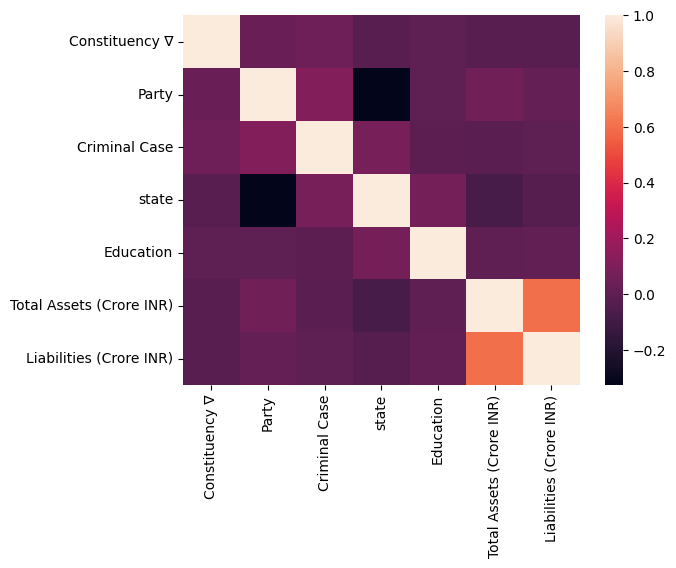

In [ ]:
sns.heatmap(df_train.corr())

In [ ]:
X_pred = process_test_data(test)
X_pred.head()

In [ ]:
from sklearn.model_selection import train_test_split

X = df_train.drop(['Education'], axis=1)
y = df_train['Education']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Train Random Forest classifier

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a scorer using F1 score
scorer = make_scorer(f1_score, average='weighted')

# Initialize GridSearchCV
grid_search = GridSearchCV(rf_classifier, param_grid, scoring=scorer, cv=5, n_jobs=-1)

# Perform Grid Search
grid_search.fit(X_train, y_train)

# Get the best parameters and best F1 score
best_params = grid_search.best_params_
best_f1 = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best F1 Score:", best_f1)

# Use the best model for predictions
best_rf_classifier = grid_search.best_estimator_
y_pred_best = best_rf_classifier.predict(X_test)

# Calculate F1 score for the best model
f1_best = f1_score(y_test, y_pred_best, average='weighted')

print("F1 Score with Best Random Forest Classifier:", f1_best)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Best F1 Score: 0.24078564218931625
F1 Score with Best Random Forest Classifier: 0.2088461540909956


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# Initialize the Multinomial Naive Bayes Classifier
nb_classifier = MultinomialNB()

# Define the parameter grid to search (Note: Naive Bayes does not have the same hyperparameters as Random Forest)
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0]  # Alpha is the Laplace smoothing parameter
}

# Create a scorer using F1 score
scorer = make_scorer(f1_score, average='weighted')

# Initialize GridSearchCV
grid_search = GridSearchCV(nb_classifier, param_grid, scoring=scorer, cv=5, n_jobs=-1)

# Perform Grid Search
grid_search.fit(X_train, y_train)

# Get the best parameters and best F1 score
best_params = grid_search.best_params_
best_f1 = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best F1 Score:", best_f1)

# Use the best model for predictions
best_nb_classifier = grid_search.best_estimator_
y_pred_best = best_nb_classifier.predict(X_test)

# Calculate F1 score for the best model
f1_best = f1_score(y_test, y_pred_best, average='weighted')

print("F1 Score with Best Naive Bayes Classifier:", f1_best)

Best Parameters: {'alpha': 0.1}
Best F1 Score: 0.13764801546784663
F1 Score with Best Naive Bayes Classifier: 0.12153870760939657


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# Initialize the Support Vector Machine (SVM) Classifier
svm_classifier = SVC()

# Define the parameter grid to search
param_grid = {
    'C': [0.1, 1, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Kernel type
    'gamma': ['auto'],  # Kernel coefficient
}

# Create a scorer using F1 score
scorer = make_scorer(f1_score, average='weighted')

# Initialize GridSearchCV
grid_search = GridSearchCV(svm_classifier, param_grid, scoring=scorer, cv=5, n_jobs=-1)

# Perform Grid Search
grid_search.fit(X_train, y_train)

# Get the best parameters and best F1 score
best_params = grid_search.best_params_
best_f1 = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best F1 Score:", best_f1)

# Use the best model for predictions
best_svm_classifier = grid_search.best_estimator_
y_pred_best = best_svm_classifier.predict(X_test)

# Calculate F1 score for the best model
f1_best = f1_score(y_test, y_pred_best, average='weighted')

print("F1 Score with Best SVM Classifier:", f1_best)

KeyboardInterrupt: 

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# Initialize the XGBoost Classifier
xgb_classifier = xgb.XGBClassifier()

# Define the parameter grid to search
param_grid = {
    'gamma': [0, 0.1, 0.2],
    'learning_rate': [0.01, 0.1, 0.3],
}

# Create a scorer using F1 score
scorer = make_scorer(f1_score, average='weighted')

# Initialize GridSearchCV
grid_search = GridSearchCV(xgb_classifier, param_grid, scoring=scorer, cv=5, n_jobs=-1)

# Perform Grid Search
grid_search.fit(X_train, y_train)

# Get the best parameters and best F1 score
best_params = grid_search.best_params_
best_f1 = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best F1 Score:", best_f1)

# Use the best model for predictions
best_xgb_classifier = grid_search.best_estimator_
y_pred_best = best_xgb_classifier.predict(X_test)

# Calculate F1 score for the best model
f1_best = f1_score(y_test, y_pred_best, average='weighted')

print("F1 Score with Best XGBoost Classifier:", f1_best)

In [ ]:
best_rf_classifier = RandomForestClassifier(n_estimators=300, max_depth=None, min_samples_split=10, min_samples_leaf=1, random_state=42)

# Train the best model on the entire training data
best_rf_classifier.fit(X_train, y_train)

# Make predictions on new data X_new
y_pred_new = best_rf_classifier.predict(X_pred)
y_pred_new

array([5, 9, 5, ..., 9, 0, 9])

In [ ]:
le = LabelEncoder()
encoding = pd.read_csv('/content/train.csv')
train_ed = le.fit_transform(encoding['Education'])
y_submit = le.inverse_transform(y_pred_new)
sub = pd.DataFrame(y_submit, columns=['Education'])
sub['ID'] = range(0, len(sub))  # Adding ID starting from 0
sub = sub[['ID', 'Education']]
# Save the DataFrame to a CSV file
sub.to_csv('predictions.csv', index=False)
sub.head()

,ID,Education
0,0,Graduate
1,1,Post Graduate
2,2,Graduate
3,3,12th Pass
4,4,Graduate


from matplotlib import pyplot as plt
_df_0['ID'].plot(kind='hist', bins=20, title='ID')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('Education').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['ID']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'ID'}, axis=1)
              .sort_values('ID', ascending=True))
  xs = counted['ID']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_2.sort_values('ID', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Education')):
  _plot_series(series, series_name, i)
  fig.legend(title='Education', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ID')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_3['ID'].plot(kind='line', figsize=(8, 4), title='ID')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_4['Education'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_4, x='ID', y='Education', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)